In [2]:
import pandas as pd
import cudf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
import feather
df = feather.read_dataframe('feature/train_feature.feather')

In [4]:
# 去除特征值含有 inf 的样本
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [ ]:
# df = cudf.from_pandas(df)
# 取 2014-12-18 作为验证集
df_check = df[df['pred_date'] == pd.Timestamp('2014-12-18')]
# 取 2014-12-16、2014-12-17 作为训练集
df = df[df['pred_date'] <= pd.Timestamp('2014-12-17')]

In [5]:
# 分离特征和标签
X = df.drop(['user_id', 'item_id', 'pred_date','label'], axis=1).values
y = df['label'].values
# X_check = df_check.drop(['user_id', 'item_id', 'pred_date','label'], axis=1).values
# y_check = df_check['label'].values

In [5]:
# 特征选择（使用 SelectKBest 和 f_classif）
# selector = SelectKBest(score_func = f_classif, k = 10)
# X = selector.fit_transform(X, y)

# 数据预处理（标准化）
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X = scaler.transform(X)

In [8]:

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
def f1_score(preds, dtrain):
    labels = dtrain > 0.5
    preds = preds > 0.5  # 根据概率阈值确定预测类别（假设二分类，阈值为0.5）
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    return f1

In [9]:
# 初始化 XGBoost 分类器并设置 GPU 相关参数
model = xgb.XGBClassifier(
    tree_method = "hist",
    device = "cuda",
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 100,
    objective = 'binary:logistic',
    random_state = 42
)

In [10]:
# 训练模型
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.14767
[1]	validation_0-logloss:0.13078
[2]	validation_0-logloss:0.11682
[3]	validation_0-logloss:0.10485
[4]	validation_0-logloss:0.09443
[5]	validation_0-logloss:0.08526
[6]	validation_0-logloss:0.07716
[7]	validation_0-logloss:0.06997
[8]	validation_0-logloss:0.06357
[9]	validation_0-logloss:0.05785
[10]	validation_0-logloss:0.05274
[11]	validation_0-logloss:0.04817
[12]	validation_0-logloss:0.04406
[13]	validation_0-logloss:0.04038
[14]	validation_0-logloss:0.03708
[15]	validation_0-logloss:0.03411
[16]	validation_0-logloss:0.03143
[17]	validation_0-logloss:0.02902
[18]	validation_0-logloss:0.02684
[19]	validation_0-logloss:0.02488
[20]	validation_0-logloss:0.02311
[21]	validation_0-logloss:0.02151
[22]	validation_0-logloss:0.02007
[23]	validation_0-logloss:0.01877
[24]	validation_0-logloss:0.01759
[25]	validation_0-logloss:0.01653
[26]	validation_0-logloss:0.01557
[27]	validation_0-logloss:0.01470
[28]	validation_0-logloss:0.01392
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

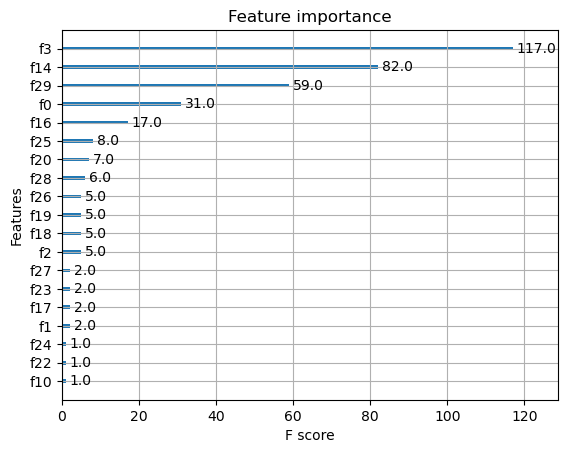

In [11]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(model)
plt.show() 

In [22]:
thresholds = np.sort(model.feature_importances_)
threshold = thresholds[-5]

In [23]:
threshold

np.float32(0.0020630374)

In [24]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(model, threshold=threshold, prefit=True)
select_X_train = selection.transform(X_train)
select_X_train.shape[1]

5

In [25]:
model_sel = xgb.XGBClassifier(
    tree_method = "hist",
    device = "cuda",
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 100,
    objective = 'binary:logistic',
    random_state = 42
)
model_sel.fit(select_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [28]:
from datetime import datetime
# 保存模型
model_sel.save_model('model/XGBoost/model_sel_{:}.model'.format(datetime.now().strftime('%m%d%H%M')))
import pickle
# 保存特征选择器
pickle.dump(selection, open('model/XGBoost/selection_{:}.pkl'.format(datetime.now().strftime('%m%d%H%M')), 'wb'))
# 保存标准化器
pickle.dump(scaler, open('model/XGBoost/scaler_{:}.pkl'.format(datetime.now().strftime('%m%d%H%M')), 'wb'))

/data/gyh/envs/rapids-24.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732224315218/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [6]:
model = xgb.XGBClassifier()
model.load_model('model/XGBoost/model_rank10_01171856')
import pickle
scaler = pickle.load(open('model/XGBoost/scaler_01171856.pkl', 'rb'))

In [21]:
item_data = feather.read_dataframe('dataset/item_data.feather')
item_data.drop(['item_geohash', 'item_category'], axis=1, inplace=True)

In [ ]:
from datetime import datetime
# 保存模型
model.save_model('model/XGBoost/model_{:}'.format(datetime.now().strftime('%m%d%H%M')))
# # 保存特征选择器
# import pickle
# with open('model/XGBoost/selector_{:}.pkl'.format(datetime.now().strftime('%m%d%H%M')), 'wb') as f:
#     pickle.dump(selector, f)

In [29]:
import feather
\
# 读取预测数据
df = feather.read_dataframe('feature/pred_feature.feather')
df_id = df[['user_id', 'item_id']]
df_X = df.drop(columns=['user_id', 'item_id'])
if 'index_x' in df.columns:
    df_X = df_X.drop(columns=['index_x', 'index_y'])
df_X = df_X.values
df_X = df_X[~np.isinf(df_X).any(axis=1)]

In [30]:
model = model_sel

In [31]:
# 对预测数据进行特征选择和数据预处理
# df_X = selector.transform(df_X)
df_X = scaler.transform(df_X)

# 进行预测
df_y = model.predict_proba(df_X)

ValueError: Feature shape mismatch, expected: 5, got 30

In [ ]:
# 特征选择
df_X = selection.transform(df_X)

# 进行预测
df_y = model_sel.predict_proba(df_X)

In [17]:
df_id['prob'] = df_y[:,1]

/tmp/ipykernel_2450703/3462327973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['prob'] = df_y[:,1]


In [19]:
df_id.sort_values(by=['prob'], ascending=[False], inplace=True)

/tmp/ipykernel_2450703/2146593489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id.sort_values(by=['prob'], ascending=[False], inplace=True)


In [22]:
result = df_id.merge(item_data, on='item_id', how='inner')

In [26]:
from datetime import datetime
# 输出前 300000 条数据
result.head(300000)[['user_id','item_id']].to_csv('result/XGBoost/result_300000_{:}.txt'.format(datetime.now().strftime('%m%d%H%M')), index=False, header=False, sep='\t')

In [ ]:

# 将正样本对应的df_id保存到文件
df_id['label'] = df_y
df_id = df_id[df_id['label'] == 1]
df_id = df_id.drop(columns=['label'])
df_id.to_csv('result/XGBoost/result_{:}.txt'.format(datetime.now().strftime('%m%d%H%M')), index=False, header=False, sep='\t')

In [13]:
df_id.to_csv('result/XGBoost/result_{:}.txt'.format(datetime.now().strftime('%m%d%H%M')), index=False, header=False, sep='\t')